# 1 Scraping the data
This code was made to obtain the data from the Wikipedia page https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M

In [2]:
import pandas as pd

In [3]:
df_pc = pd.read_html('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M')[0]

In [4]:
#Filter the rows which have a 'Not assigned' Borough
df_pc = df_pc[df_pc.Borough != 'Not assigned']

In [5]:
df_pc.head()

,Postal Code,Borough,Neighborhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
5,M6A,North York,"Lawrence Manor, Lawrence Heights"
6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


In [6]:
df_pc.shape

(103, 3)

# 2 Getting the geoespacial data
This code is to get the latitude and longitude coordinates of the neighborhoods

In [7]:
df_geo = pd.read_csv('http://cocl.us/Geospatial_data')

In [8]:
df = df_pc.merge(df_geo, on='Postal Code')

In [9]:
df.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


# 3 Explore and cluster the neighborhoods in Toronto
## Collecting the information about the venues.
This code is for collecting the venues information in order to cluster the neighborhoods

In [22]:
#Import the necesary libraríes
import requests
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
#!pip install folium
import folium

In [14]:
radius = 500
LIMIT = 100
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    """A function to obtain the neighborhood's nearby venues. It sends a requests to the foursquare API"""
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):            
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [107]:
#Call the function and shows the result
toronto_venues = getNearbyVenues(df_toronto.Neighborhood,df_toronto.Latitude,df_toronto.Longitude)
toronto_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Regent Park, Harbourfront",43.65426,-79.360636,Roselle Desserts,43.653447,-79.362017,Bakery
1,"Regent Park, Harbourfront",43.65426,-79.360636,Tandem Coffee,43.653559,-79.361809,Coffee Shop
2,"Regent Park, Harbourfront",43.65426,-79.360636,Cooper Koo Family YMCA,43.653249,-79.358008,Distribution Center
3,"Regent Park, Harbourfront",43.65426,-79.360636,Body Blitz Spa East,43.654735,-79.359874,Spa
4,"Regent Park, Harbourfront",43.65426,-79.360636,Dominion Pub and Kitchen,43.656919,-79.358967,Pub


In [17]:
#One hot encode the venue category
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 
column_names = list(toronto_onehot.columns)
column_names.remove('Neighborhood')
fixed_columns = ['Neighborhood'] + column_names
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Neighborhood,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean()

In [29]:
#Get the top 10 venues for each of the Neighborhoods
df_top10venues = pd.DataFrame(toronto_grouped.columns.values[np.argsort(-toronto_grouped.values, axis=1)[:, :10]], 
                  index=toronto_grouped.index,
                  columns = ['1st Most Common Venue', '2nd Most Common Venue', '3rd Most Common Venue', '4th Most Common Venue',
                             '5th Most Common Venue', '6th Most Common Venue', '7th Most Common Venue', '8th Most Common Venue', 
                             '9th Most Common Venue', '10th Most Common Venue']).reset_index()

## This part of the notebook has the code to implement the Kmeans algorithm and show the results


In [108]:
kmeans = KMeans(n_clusters=5,random_state=0).fit(toronto_grouped)

In [51]:
df_top10venues.insert(0,'Cluster Labels',kmeans.labels_)

In [73]:
# I implemented a Principal Component Analisis to reduce the number of features and create a scatter plot of the result in order to
# visualize the clusters
pca = PCA(n_components=2)
pca_elements = pca.fit_transform(toronto_grouped)
pca_centers = pca.transform(kmeans.cluster_centers_)

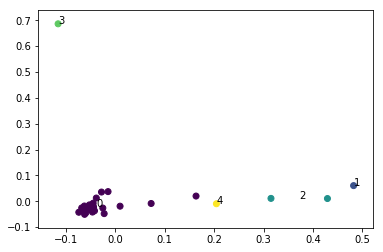

In [83]:
#Create the scatter plot and add some annotations to identify the different clusters.
plt.scatter(list(map(lambda x:x[0],pca_elements)),list(map(lambda x:x[1],pca_elements)),c=kmeans.labels_)
for i,center in enumerate(pca_centers):
    plt.annotate(i,xy=center)

In [91]:
toronto_merged = df_top10venues.merge(df_toronto,on='Neighborhood')

## Visualize the results in the map

In [133]:
latitude = 43.679563
longitude = -79.377529
kclusters = kmeans.n_clusters

map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Examine Clusters

### Cluster 1

In [128]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[list(range(1,12))]].head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berczy Park,Coffee Shop,Cocktail Bar,Beer Bar,Seafood Restaurant,Cheese Shop,Bakery,Restaurant,Café,Bistro,Lounge
1,"Brockton, Parkdale Village, Exhibition Place",Café,Coffee Shop,Breakfast Spot,Bakery,Gym,Pet Store,Performing Arts Venue,Office,Restaurant,Climbing Gym
2,"Business reply mail Processing Centre, South C...",Yoga Studio,Fast Food Restaurant,Skate Park,Pizza Place,Burrito Place,Butcher,Light Rail Station,Brewery,Garden Center,Restaurant
3,"CN Tower, King and Spadina, Railway Lands, Har...",Airport Service,Airport Lounge,Airport Terminal,Plane,Boutique,Boat or Ferry,Sculpture Garden,Rental Car Location,Coffee Shop,Airport
4,Central Bay Street,Coffee Shop,Sandwich Place,Italian Restaurant,Café,Japanese Restaurant,Bubble Tea Shop,Salad Place,Burger Joint,Bar,Thai Restaurant


### Cluster 2

In [129]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[list(range(1,12))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
20,"Moore Park, Summerhill East",Gym,Trail,Market,Martial Arts Dojo,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant


### Cluster 3

In [132]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[list(range(1,12))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
12,"Forest Hill North & West, Forest Hill Road Park",Park,Trail,Jewelry Store,Sushi Restaurant,Afghan Restaurant,Market,Martial Arts Dojo,Mediterranean Restaurant,Men's Store,Mexican Restaurant
26,Rosedale,Park,Playground,Trail,Afghan Restaurant,Market,Martial Arts Dojo,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant


### Cluster 4

In [131]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[list(range(1,12))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
27,Roselawn,Music Venue,Garden,Afghan Restaurant,Market,Martial Arts Dojo,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop
